# **Imports**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras import Input
from keras.metrics import Precision, Recall
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, SeparableConv2D
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import cv2
import os

# **Loading the dataset and visualizing it**

Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


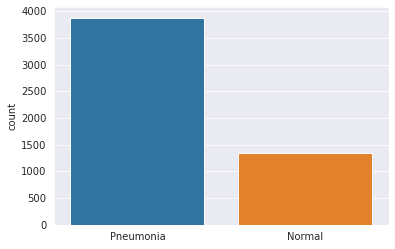

In [2]:
path = '../input/chest-xray-pneumonia/chest_xray/chest_xray/'

for comb in ['train', 'val', 'test']:
    normal = len(os.listdir(path + comb + '/NORMAL'))
    pneumonia = len(os.listdir(path + comb + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(comb, normal, pneumonia))
    if comb == 'train':
        bar_count = []
        bar_count.extend(["Pneumonia" for i in range(pneumonia)])
        bar_count.extend(["Normal" for i in range(normal)])
        sns.set_style('darkgrid')
        sns.countplot(bar_count)

# **Preprocessing data**

In [3]:
def process_data(batch_size):
    # We normalize the data (cnn converges faster on [0..1] data than [0..255])
    # And in order to avoid overfitting we artifcially expand our data set using parameters such 
    #as zoom_range, vertical_flip etc.
    train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.3, vertical_flip = True) 
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # Obtains image with the definded bach size which will be useful later when we fit the model
    train_gen = train_datagen.flow_from_directory(
                 directory = path + 'train', 
                 target_size = (150, 150), 
                 batch_size = batch_size, 
                 class_mode = 'binary', 
                 shuffle = True)

    test_gen = test_val_datagen.flow_from_directory(
                directory = path + 'test', 
                target_size = (150, 150), 
                batch_size = batch_size, 
                class_mode = 'binary', 
                shuffle = True)
    
    # The predictions will be based on one batch size
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(path + 'test' + cond)):
            img = plt.imread(path+'test'+cond+img)
            img = cv2.resize(img, (150, 150))
            # Such that the shape of the images is (150, 150, 3)
            img = np.dstack([img, img, img])
            # We normalize the data again ([0..255 --> 0..1])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [4]:
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# **Training the Model:**
- **Conv2D** -> Creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
- **BatchNormalization** -> Method used to make artificial neural networks faster and more stable through normalization of the input layer. 
- **MaxPool2D** -> It states the maximum output within a rectangular neighbourhood.
- **Dropout** -> Is regularization technique to avoid overfitting (increase ther validation accuracy) thus increasing the generalizing power.

In [5]:
def conv_block(filters):
    block = Sequential([
        SeparableConv2D(filters, (3,3), activation='relu', padding='same'),
        SeparableConv2D(filters, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D((2,2))
    ])
    
    return block

In [6]:
def dense_block(units, dropout_rate):
    block = Sequential([
        Dense(units, activation='relu'),
        Dropout(dropout_rate)
    ])
    
    return block

In [7]:

model = Sequential([
    # First (input) convutional block
    Input(shape=(150,150, 3)),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    MaxPool2D((2,2), padding = 'same'),
    
    # Second convutional block
    conv_block(32),

    # Third convutional block
    conv_block(64),
    
    # Fourth convutional block
    conv_block(128),
    Dropout(0.2),
    
    # Fifth convutional block
    conv_block(256),
    Dropout(0.2),
    
    Flatten(),
    dense_block(512, 0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    Dense(1, activation = 'sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

# Callbacks

checkpoint = ModelCheckpoint(filepath='best_weights.h5', save_best_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(patience=10, restore_best_weights=True)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 37, 37, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 18, 18, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 9, 9, 128)         27072     
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 128)        

In [8]:
hist = model.fit(
           train_gen, steps_per_epoch = train_gen.samples // batch_size, 
           epochs = epochs, 
           validation_data = test_gen, 
           validation_steps = test_gen.samples // batch_size, 
           callbacks=[checkpoint, early_stop, lr_reduce])

Epoch 1/10
163/163 [==============================] - 117s 694ms/step - loss: 0.4963 - accuracy: 0.7693 - val_loss: 0.7583 - val_accuracy: 0.6299
Epoch 2/10
163/163 [==============================] - 78s 481ms/step - loss: 0.2593 - accuracy: 0.8967 - val_loss: 0.8950 - val_accuracy: 0.6283
Epoch 3/10
163/163 [==============================] - 78s 481ms/step - loss: 0.2394 - accuracy: 0.9095 - val_loss: 1.1211 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 79s 484ms/step - loss: 0.2253 - accuracy: 0.9179 - val_loss: 1.3021 - val_accuracy: 0.6217
Epoch 5/10
163/163 [==============================] - 78s 481ms/step - loss: 0.1974 - accuracy: 0.9294 - val_loss: 0.2813 - val_accuracy: 0.8882
Epoch 6/10
163/163 [==============================] - 77s 474ms/step - loss: 0.2035 - accuracy: 0.9208 - val_loss: 0.3499 - val_accuracy: 0.8651

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/10
163/163 [============================

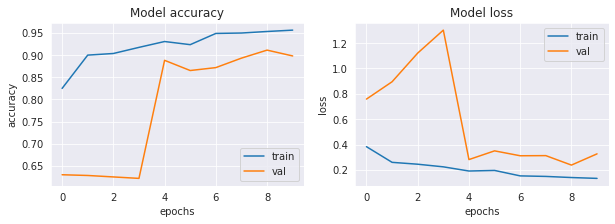

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[173  61]
 [  6 384]]

TEST METRICS ----------------------
Accuracy: 89.26282051282051%
Precision: 86.29213483146067%
Recall: 98.46153846153847%
F1-score: 91.97604790419163

TRAIN METRIC ----------------------
Train acc: 95.63
